[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/haroldcha/gunviolencedata/blob/master/causal_inference.ipynb)


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt

Using difference-in-difference, we can see if our selected intervention, the 2014 Act 192, caused an increase in injuries + fatalities per incident. Our hypothesis is that if gun advocates can sue Philadelphia municipalities for gun legislation, more violent guns will be available and there will be a higher injury + death rate per gun incident.

Our value of interest $y$ is the number of deaths in a given incident. Our treatment value $T$ is a binary value indicating 1 if the incident occurred in South Philadelphia, PA or 0 if in Camden, NJ. We also have a value $I$ to indicate 1 if the violent incident occurred after the intervention, and 0 if it occurred before.

Since South Philadelphia and Camden are adjacent, we can exclude confounders such as weather, geography, etc. We'll be controlling for population density, median household income, unemployment rates, and the median age.

In [ ]:
phil_camden = pd.read_csv('https://raw.githubusercontent.com/haroldcha/gunviolencedata/master/philadelphia_camden_gun_violence.csv')

In [ ]:
phil_camden

,Unnamed: 0,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,...,participant_type,sources,state_house_district,state_senate_district,datetime,year,state_pop,city_pop,area (sq. mi),pop_density
0,288,92423,2014-01-01,Pennsylvania,Philadelphia,34th Street and Haverford Avenue,0,1,http://www.gunviolencearchive.org/incident/92423,http://www.philly.com/philly/blogs/dncrime/Man...,...,0::Victim||1::Subject-Suspect,http://www.philly.com/philly/blogs/dncrime/Man...,NaN,NaN,2014-01-01,2014,12788313,1565460.0,46058,277.656715
1,297,92747,2014-01-01,New Jersey,Camden,NaN,0,1,http://www.gunviolencearchive.org/incident/92747,http://www.courierpostonline.com/article/20140...,...,0::Victim||1::Subject-Suspect,http://www.courierpostonline.com/article/20140...,5.0,5.0,2014-01-01,2014,8864525,75673.0,8722,1016.340862
2,532,92349,2014-01-02,Pennsylvania,Philadelphia,7th Street,0,1,http://www.gunviolencearchive.org/incident/92349,http://www.philly.com/philly/blogs/dncrime/S-P...,...,0::Victim||1::Victim||2::Subject-Suspect,http://www.philly.com/philly/blogs/dncrime/S-P...,NaN,NaN,2014-01-02,2014,12788313,1565460.0,46058,277.656715
3,557,220357,2014-01-02,Pennsylvania,Philadelphia,34th and Haverford Avenue,0,1,http://www.gunviolencearchive.org/incident/220357,http://blog.phillypolice.com/2014/02/wanted-su...,...,0::Victim||1::Subject-Suspect,http://blog.phillypolice.com/2014/02/wanted-su...,NaN,NaN,2014-01-02,2014,12788313,1565460.0,46058,277.656715
4,604,92727,2014-01-02,New Jersey,Camden,1600 block of Louis Street,1,0,http://www.gunviolencearchive.org/incident/92727,http://www.nj.com/camden/index.ssf/2014/01/cam...,...,0::Victim,http://www.nj.com/camden/index.ssf/2014/01/cam...,5.0,5.0,2014-01-02,2014,8864525,75673.0,8722,1016.340862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,235382,1062115,2018-03-04,Pennsylvania,Philadelphia,N 6th St and Spring Garden St,1,1,http://www.gunviolencearchive.org/incident/106...,http://6abc.com/1-killed-1-injured-in-spring-g...,...,0::Victim||1::Victim,http://philadelphia.cbslocal.com/2018/03/04/po...,181.0,1.0,2018-03-04,2018,12800922,1583592.0,46058,277.930479
605,235559,1063484,2018-03-05,New Jersey,Camden,400 block of Mechanic St,1,0,http://www.gunviolencearchive.org/incident/106...,http://www.nj.com/camden/index.ssf/2018/03/man...,...,0::Victim,https://www.courierpostonline.com/story/news/c...,5.0,5.0,2018-03-05,2018,8886025,73725.0,8722,1018.805893
606,236316,1066841,2018-03-10,Pennsylvania,Philadelphia,200 block of Lombard St,0,1,http://www.gunviolencearchive.org/incident/106...,http://6abc.com/parking-lot-attendant-shot-dur...,...,0::Victim,http://6abc.com/parking-lot-attendant-shot-dur...,175.0,1.0,2018-03-10,2018,12800922,1583592.0,46058,277.930479
607,237129,1070055,2018-03-15,Pennsylvania,Philadelphia,700 block of S Columbus Blvd,0,0,http://www.gunviolencearchive.org/incident/107...,http://6abc.com/2-men-run-from-south-philly-tr...,...,0::Subject-Suspect||1::Subject-Suspect,http://6abc.com/2-men-run-from-south-philly-tr...,175.0,1.0,2018-03-15,2018,12800922,1583592.0,46058,277.930479


In [ ]:
phil_camden['median_income'] = 26214
phil_camden.loc[phil_camden['city_or_county'] == 'Philadelphia', 'median_income'] = 45300

phil_camden['unemployment'] = 0.093
phil_camden.loc[phil_camden['city_or_county'] == 'Philadelphia', 'unemployment'] = 0.072

phil_camden

,Unnamed: 0,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,...,state_house_district,state_senate_district,datetime,year,state_pop,city_pop,area (sq. mi),pop_density,median_income,unemployment
0,288,92423,2014-01-01,Pennsylvania,Philadelphia,34th Street and Haverford Avenue,0,1,http://www.gunviolencearchive.org/incident/92423,http://www.philly.com/philly/blogs/dncrime/Man...,...,NaN,NaN,2014-01-01,2014,12788313,1565460.0,46058,277.656715,45300,0.072
1,297,92747,2014-01-01,New Jersey,Camden,NaN,0,1,http://www.gunviolencearchive.org/incident/92747,http://www.courierpostonline.com/article/20140...,...,5.0,5.0,2014-01-01,2014,8864525,75673.0,8722,1016.340862,26214,0.093
2,532,92349,2014-01-02,Pennsylvania,Philadelphia,7th Street,0,1,http://www.gunviolencearchive.org/incident/92349,http://www.philly.com/philly/blogs/dncrime/S-P...,...,NaN,NaN,2014-01-02,2014,12788313,1565460.0,46058,277.656715,45300,0.072
3,557,220357,2014-01-02,Pennsylvania,Philadelphia,34th and Haverford Avenue,0,1,http://www.gunviolencearchive.org/incident/220357,http://blog.phillypolice.com/2014/02/wanted-su...,...,NaN,NaN,2014-01-02,2014,12788313,1565460.0,46058,277.656715,45300,0.072
4,604,92727,2014-01-02,New Jersey,Camden,1600 block of Louis Street,1,0,http://www.gunviolencearchive.org/incident/92727,http://www.nj.com/camden/index.ssf/2014/01/cam...,...,5.0,5.0,2014-01-02,2014,8864525,75673.0,8722,1016.340862,26214,0.093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,235382,1062115,2018-03-04,Pennsylvania,Philadelphia,N 6th St and Spring Garden St,1,1,http://www.gunviolencearchive.org/incident/106...,http://6abc.com/1-killed-1-injured-in-spring-g...,...,181.0,1.0,2018-03-04,2018,12800922,1583592.0,46058,277.930479,45300,0.072
605,235559,1063484,2018-03-05,New Jersey,Camden,400 block of Mechanic St,1,0,http://www.gunviolencearchive.org/incident/106...,http://www.nj.com/camden/index.ssf/2018/03/man...,...,5.0,5.0,2018-03-05,2018,8886025,73725.0,8722,1018.805893,26214,0.093
606,236316,1066841,2018-03-10,Pennsylvania,Philadelphia,200 block of Lombard St,0,1,http://www.gunviolencearchive.org/incident/106...,http://6abc.com/parking-lot-attendant-shot-dur...,...,175.0,1.0,2018-03-10,2018,12800922,1583592.0,46058,277.930479,45300,0.072
607,237129,1070055,2018-03-15,Pennsylvania,Philadelphia,700 block of S Columbus Blvd,0,0,http://www.gunviolencearchive.org/incident/107...,http://6abc.com/2-men-run-from-south-philly-tr...,...,175.0,1.0,2018-03-15,2018,12800922,1583592.0,46058,277.930479,45300,0.072


In [ ]:
def parse_age(age_string):
    if type(age_string) != str:
        return None
    
    ages = []
    age_split = []
    if '||' in age_string:
        age_split = age_string.split('||')
    elif '|' in age_string:
        age_split = age_string.split('|')
    else:
        age_split = [age_string]
    
    for age in age_split:
        if '::' in age:
            ages.append(int(age.split('::')[-1]))
        elif ':' in age:
            ages.append(int(age.split(':')[-1]))
        else:
            return None

    return np.mean(ages)

In [ ]:
phil_camden['mean_participant_age'] = phil_camden['participant_age'].apply(parse_age)

In [ ]:
did_df = phil_camden[['year', 'city_or_county', 'n_killed', 'n_injured', 'median_income', 'pop_density', 'unemployment', 'mean_participant_age']]
did_df = did_df.dropna()

did_df['T'] = 0
did_df.loc[did_df['city_or_county'] == 'Philadelphia', 'T'] = 1

did_df['I'] = 0
did_df.loc[did_df['year'] > 2014, 'I'] = 1

did_df['y'] = did_df['n_killed'] + did_df['n_injured']

did_df['T*I'] = did_df['T']

did_df = did_df[['y', 'T', 'I', 'T*I', 'median_income', 'pop_density', 'unemployment', 'mean_participant_age']]
did_df

,y,T,I,T*I,median_income,pop_density,unemployment,mean_participant_age
0,1,1,0,1,45300,277.656715,0.072,18.0
3,1,1,0,1,45300,277.656715,0.072,18.0
4,1,0,0,0,26214,1016.340862,0.093,39.0
5,1,1,0,1,45300,277.656715,0.072,19.0
6,1,1,0,1,45300,277.656715,0.072,31.0
...,...,...,...,...,...,...,...,...
602,1,1,1,1,45300,277.930479,0.072,59.0
603,1,1,1,1,45300,277.930479,0.072,17.0
604,2,1,1,1,45300,277.930479,0.072,32.0
605,1,0,1,0,26214,1018.805893,0.093,41.0


Using OLS, we can find the equivalent value of the difference-in-difference estimate of the policy effect. That is, we can find the mean number of deaths before and after Act 192 in the Philadelphia treatment group, and the mean number of deaths before and after Act 192 in the Camden control group, and calculate the difference between these means. This is because our averages are just expected values from our estimator.

The reason we use OLS is to easily include our four confounders as well as calculating errors.

To do this, we can estimate the unknown parameters in $y = \beta_0 + \beta_1 T + \beta_2 I + \beta_3 TI + \beta_4 X_1 + \beta_5 X_2 + \beta_6 X_3 + \beta_7 X_4$ where $X_i$ is the $i^{th}$ confounder in our dataset.

In [ ]:
X = did_df.loc[:, did_df.columns != 'y']
Y = did_df['y']

model = sm.OLS(Y, X)
results = model.fit()
results.params

T                       80.069005
I                        0.176325
T*I                     80.069005
median_income           -0.004166
pop_density              0.108780
unemployment            -7.103068
mean_participant_age    -0.001602
dtype: float64

We can visualize this result by plotting the mean number of injuries + deaths pre and post intervention, segregated by treatment.

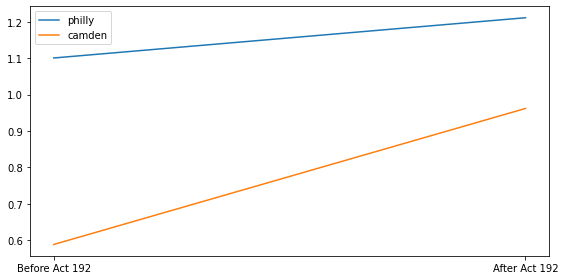

In [ ]:
did_df_treatment = did_df[did_df['T'] == 1]
did_df_control = did_df[did_df['T'] == 0]

mean_treatment_before = np.mean(did_df_treatment[did_df_treatment['I'] == 0]['y'])
mean_treatment_after = np.mean(did_df_treatment[did_df_treatment['I'] == 1]['y'])

mean_control_before = np.mean(did_df_control[did_df_control['I'] == 0]['y'])
mean_control_after = np.mean(did_df_control[did_df_control['I'] == 1]['y'])

fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True)
plt.plot([0, 1], [mean_treatment_before, mean_treatment_after], label='philly')
ax.set_xticks([0, 1])
plt.plot([0, 1], [mean_control_before, mean_control_after], label='camden')
ax.set_xticklabels(['Before Act 192', 'After Act 192'])
plt.legend()
plt.show()

**Simple Version of Difference-in-Difference Calculation**

In [ ]:
#Difference-in-difference (before)
mean_treatment_before - mean_control_before

0.5126821370750135

In [ ]:
#Difference-in-difference (after)
mean_treatment_after - mean_control_after

0.2494172494172493

**Difference-in-Difference Using Fit OLS Model**

In [ ]:
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    """
    Fits an OLS model from data.
    
    Inputs:
        df: pandas DataFrame
        target_variable: string, name of the target variable
        explanatory_variables: list of strings, names of the explanatory variables
        intercept: bool, if True add intercept term
    Outputs:
        fitted_model: model containing OLS regression results
    """
    
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)


In [ ]:
linear_model = fit_OLS_model(did_df, 'y', ['T', 'I', 'T*I', 'median_income', 'pop_density', 'unemployment', 'mean_participant_age'], intercept=True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     11.94
Date:                Tue, 03 May 2022   Prob (F-statistic):           3.08e-09
Time:                        04:04:04   Log-Likelihood:                -446.12
No. Observations:                 465   AIC:                             902.2
Df Residuals:                     460   BIC:                             923.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -46.1205 

# Analysis
Observing the Fit OLS model generated based on our target variable "Y" (the sum of Gun Violence injuries and deaths) against our treatment variable (Act of 192) and confounding variables (median income, population density, unemployment, and mean of participant's age) the constant coefficient demonstrated negative number of -46.1205, which signifies negative relationship between our target variable against our confounding variables before and after intervention of Act of 192. This also signifies that the general number of injuries and deaths from gun violence incidents have gone down over time, which was also demonstrated from our previous analysis that showed decreasing number of gun violence cases over time due to increasing number of gun control federal state laws that were instated throughout the entire nation. 

As indicated from the summary of the fit OLS model, standard errors are fairly high for our target variable which might not entire represent our population. The standard error was 24.137 for our constant. 

In our conclusion, given the high error rate from our OLS model, we discovered unexpected founding on the correlation between treatment variable of Act of 192 intervention and our target variable on the overall number of injuries and deaths from gun violence cases. Therefore, we came to conclusion that it is hard to demonstrate causality between our treatment and target variables.

In [ ]:
#explain the coefficients of confounding variables and the impacts. 
#add part about errors and uncertainty.
#indicate that standard error was very high.